In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../../")

import numpy as np

%matplotlib widget

In [ ]:
from weylchamber import c1c2c3
from qiskit import QuantumCircuit
from src.utils.custom_gates import RiSwapGate
from qiskit.quantum_info import Operator

In [ ]:
# class pass_manager_basic(PassManager):
#     def __init__(self, gate='iswap'):
#         passes = []
#         # collect 2Q blocks
#         passes.extend([Unroll3qOrMore(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)])
#         if gate == 'iswap':
#             passes.extend([decomposer(basis_gate=RiSwapGate(1/2))])
#         elif gate == 'cx':
#             passes.extend([decomposer(basis_gate=CXGate())])
#         #combine 1Q gates
#         passes.extend([Optimize1qGates()])
#         #passes.extend([CountOps(), fooAnalysis()])
#         super().__init__(passes)

In [ ]:
# #transp1 = transpile(qc, optimization_level=3, basis_gates=['u', 'id', 'cx'])
# pm = pass_manager_basic(gate='iswap')
# qc = QuantumCircuit(2)
# qc.swap(0,1)
# transp1 = pm.run(qc)

In [ ]:
# transp1.draw(output='mpl');

In [ ]:
from src.basisv2 import CircuitTemplateV2
basis = CircuitTemplateV2(n_qubits=2, base_gates = [RiSwapGate], edge_params=[[(0,1)]])
basis.build(3)
basis.spanning_range = range(3,4)

#bound all Qs to be >0
for el in basis.circuit.parameters:
    s_el = str(el)
    if 'Q' in s_el:
        basis.add_bound(s_el, 0.5, 0.5)

from src.sampler import HaarSample, GateSample
from qiskit.circuit.library import CXGate, CZGate, SwapGate
sampler = GateSample(gate = SwapGate())
s = [s for s in sampler][0]

from src.optimizer import TemplateOptimizer
from src.cost_function import BasicCostInverse, BasicCost
objective1 = BasicCost()
optimizer3 = TemplateOptimizer(basis=basis, objective=objective1, use_callback=False, override_fail=True, success_threshold = 1e-7, training_restarts=25)
_ret3 = optimizer3.approximate_target_U(s)

In [ ]:
basis.build(_ret3.cycles)
circuit =basis.assign_Xk(_ret3.Xk)
transp1 = circuit
circuit.draw()

In [ ]:
c1c2c3(Operator(transp1).data)

In [ ]:
from qiskit.circuit import Parameter
def unbind_parameters(qc):
    i = 0
    out = qc.copy()
    for instr, qargs, cargs in out:
        if instr.params and instr.name =="riswap":
            # num_params = len(instr.params)
            # pvec.resize(len(pvec) + num_params)
            instr.params = [Parameter(f't{i}')]
            i +=1
    return out

transp1 = unbind_parameters(transp1)
transp1.draw(output='mpl');

In [ ]:
from weylchamber import c1c2c3
endpoints = [5,8,11]
coordinate_list = []

for end in endpoints:
    qc = QuantumCircuit(2)
    for gate in transp1[0:end]:
        qc.append(gate[0], gate[1])

    # 2, 5, 8
    qc2 = qc.copy()
    for i in [2,5,8]:
        if i < end-3:
            qc2 = qc2.bind_parameters({qc2[i][0].params[0] : 0.5} )
    for t in np.linspace(0,.5, 25):
        qc3 = qc2.bind_parameters({qc2[end-3][0].params[0]: t})

        #eliminating x-axis symmetry
        c = list(c1c2c3(Operator(qc3).data))
        if c[0] > 0.5:
            c[0] = -1*c[0] + 1


        coordinate_list.append(c)

# qc2.draw(output='mpl');

In [ ]:
from src.utils.visualize import coordinate_2dlist_weyl
coordinate_2dlist_weyl(coordinate_list);

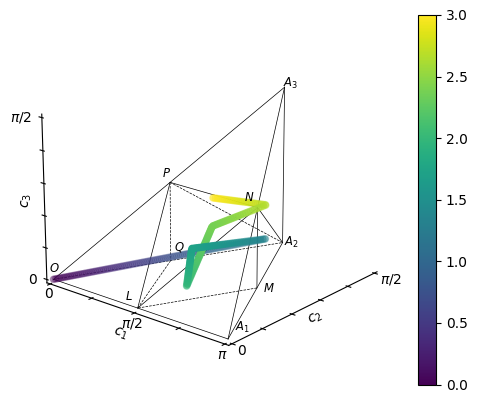

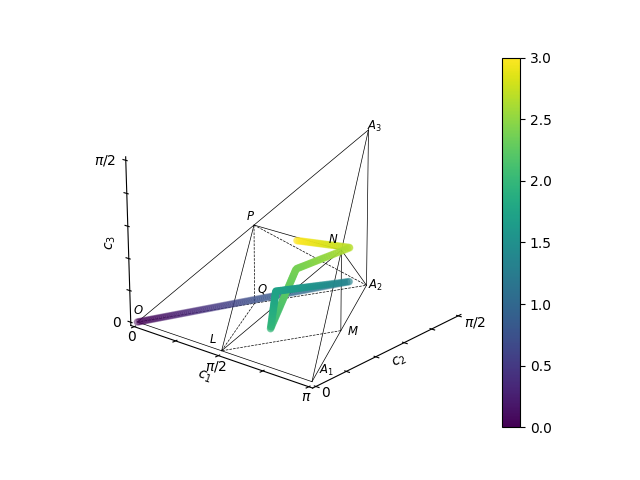

In [62]:
coordinate_list = []
from src.utils.custom_gates import FSim, BerkeleyGate, CanonicalGate
r = np.linspace(0,3,250)
for t in r:
    qc2 = QuantumCircuit(2)
    #add fsim as a function of time
    #qc2.append(FSim(1*np.pi/2, 1*np.pi/6).power(t), [0,1])
    qc2.append(CanonicalGate(np.pi / 4, np.pi / 8, np.pi/25).power(t), [0,1])
    #eliminating x-axis symmetry
    c = list(c1c2c3(Operator(qc2).data))
    # if c[0] > 0.5:
    #     c[0] = -1*c[0] + 1
    coordinate_list.append(c)
coordinate_2dlist_weyl(coordinate_list, c=r, cmap='viridis')